# SCVI Extra Covariates Tutorial

In this tutorial we will show how to train `scvi` while conditioning on extra covariates. 

This tutorial has two parts:
1.   First, we train `scvi` with only batch covariates on a dataset of Drosophila myoblast cells and show that cell sex and cell cycle confound our latent space. 
2.    Then, we train `scvi` while conditioning on the gene expression from cell sex and cell cycle marker genes. We show that `scvi` is able to deconfound cell sex and cell cycle effects while preserving signal from the other genes.







In [1]:
%%capture
import sys

BRANCH = 'master'
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet multipledispatch
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@{BRANCH}#egg=scvi-tools[tutorials]
    !pip install --quiet statannot
    !pip install --quiet gdown
    !pip install --quiet bbknn

In [2]:
import scvi
import anndata
import pandas as pd
import scanpy as sc
import numpy as np
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import plotnine as p9
from statannot import add_stat_annotation
import gdown
from scipy.stats import ranksums

sc.settings.n_jobs=10

In [3]:
sns.reset_orig()
sc.settings._vector_friendly = True
# p9.theme_set(p9.theme_classic)
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = 11
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

In [4]:
# Geary's C code from https://github.com/theislab/scanpy/pull/915
# TODO: remove this once above PR is merged into scanpy 1.8


from typing import Optional, Union

from anndata import AnnData
from multipledispatch import dispatch
import numba
import numpy as np
import pandas as pd
from scipy import sparse


def _choose_obs_rep(adata, *, use_raw=False, layer=None, obsm=None, obsp=None):
    """
    Choose array aligned with obs annotation.
    """
    is_layer = layer is not None
    is_raw = use_raw is not False
    is_obsm = obsm is not None
    is_obsp = obsp is not None
    choices_made = sum((is_layer, is_raw, is_obsm, is_obsp))
    assert choices_made <= 1
    if choices_made == 0:
        return adata.X
    elif is_layer:
        return adata.layers[layer]
    elif use_raw:
        return adata.raw.X
    elif is_obsm:
        return adata.obsm[obsm]
    elif is_obsp:
        return adata.obsp[obsp]
    else:
        assert False, (
            "That was unexpected. Please report this bug at:\n\n\t"
            " https://github.com/theislab/scanpy/issues"
        )



###############################################################################
# Calculation
###############################################################################
# Some notes on the implementation:
# * This could be phrased as tensor multiplication. However that does not get
#   parallelized, which boosts performance almost linearly with cores.
# * Due to the umap setting the default threading backend, a parallel numba
#   function that calls another parallel numba function can get stuck. This
#   ends up meaning code re-use will be limited until umap 0.4.
#   See: https://github.com/lmcinnes/umap/issues/306
# * There can be a fair amount of numerical instability here (big reductions),
#   so data is cast to float64. Removing these casts/ conversion will cause the
#   tests to fail.


@numba.njit(cache=False, parallel=False)
def _gearys_c_vec(data, indices, indptr, x):
    W = data.sum()
    return _gearys_c_vec_W(data, indices, indptr, x, W)


@numba.njit(cache=False, parallel=False)
def _gearys_c_vec_W(data, indices, indptr, x, W):
    N = len(indptr) - 1
    x_bar = x.mean()
    x = x.astype(np.float_)

    total = 0.0
    for i in numba.prange(N):
        s = slice(indptr[i], indptr[i + 1])
        i_indices = indices[s]
        i_data = data[s]
        total += np.sum(i_data * ((x[i] - x[i_indices]) ** 2))

    numer = (N - 1) * total
    denom = 2 * W * ((x - x_bar) ** 2).sum()
    C = numer / denom

    return C


@numba.njit(cache=False, parallel=False)
def _gearys_c_mtx_csr(
    g_data, g_indices, g_indptr, x_data, x_indices, x_indptr, x_shape
):
    M, N = x_shape
    W = g_data.sum()
    out = np.zeros(M, dtype=np.float_)
    for k in numba.prange(M):
        x_k = np.zeros(N, dtype=np.float_)
        sk = slice(x_indptr[k], x_indptr[k + 1])
        x_k_data = x_data[sk]
        x_k[x_indices[sk]] = x_k_data
        x_k_bar = np.sum(x_k_data) / N
        total = 0.0
        for i in numba.prange(N):
            s = slice(g_indptr[i], g_indptr[i + 1])
            i_indices = g_indices[s]
            i_data = g_data[s]
            total += np.sum(i_data * ((x_k[i] - x_k[i_indices]) ** 2))
        numer = (N - 1) * total
        # Expanded from 2 * W * ((x_k - x_k_bar) ** 2).sum(), but uses sparsity
        # to skip some calculations
        # fmt: off
        denom = (
            2 * W
            * (
                np.sum(x_k_data ** 2)
                - np.sum(x_k_data * x_k_bar * 2)
                + (x_k_bar ** 2) * N
            )
        )
        C = numer / denom
        out[k] = C
    return out


# Simplified implementation, hits race condition after umap import due to numba
# parallel backend
# @numba.njit(cache=True, parallel=True)
# def _gearys_c_mtx_csr(
#     g_data, g_indices, g_indptr, x_data, x_indices, x_indptr, x_shape
# ):
#     M, N = x_shape
#     W = g_data.sum()
#     out = np.zeros(M, dtype=np.float64)
#     for k in numba.prange(M):
#         x_arr = np.zeros(N, dtype=x_data.dtype)
#         sk = slice(x_indptr[k], x_indptr[k + 1])
#         x_arr[x_indices[sk]] = x_data[sk]
#         outval = _gearys_c_vec_W(g_data, g_indices, g_indptr, x_arr, W)
#         out[k] = outval
#     return out


@numba.njit(cache=False, parallel=False)
def _gearys_c_mtx(g_data, g_indices, g_indptr, X):
    M, N = X.shape
    W = g_data.sum()
    out = np.zeros(M, dtype=np.float_)
    for k in numba.prange(M):
        x = X[k, :].astype(np.float_)
        x_bar = x.mean()

        total = 0.0
        for i in numba.prange(N):
            s = slice(g_indptr[i], g_indptr[i + 1])
            i_indices = g_indices[s]
            i_data = g_data[s]
            total += np.sum(i_data * ((x[i] - x[i_indices]) ** 2))

        numer = (N - 1) * total
        denom = 2 * W * ((x - x_bar) ** 2).sum()
        C = numer / denom

        out[k] = C
    return out


# Similar to above, simplified version umaps choice of parallel backend breaks:
# @numba.njit(cache=True, parallel=True)
# def _gearys_c_mtx(g_data, g_indices, g_indptr, X):
#     M, N = X.shape
#     W = g_data.sum()
#     out = np.zeros(M, dtype=np.float64)
#     for k in numba.prange(M):
#         outval = _gearys_c_vec_W(g_data, g_indices, g_indptr, X[k, :], W)
#         out[k] = outval
#     return out


###############################################################################
# Interface
###############################################################################


@dispatch(sparse.csr_matrix, sparse.csr_matrix)
def gearys_c(g, vals) -> np.ndarray:
    assert g.shape[0] == g.shape[1], "`g` should be a square adjacency matrix"
    assert g.shape[0] == vals.shape[1]
    return _gearys_c_mtx_csr(
        g.data.astype(np.float_, copy=False),
        g.indices,
        g.indptr,
        vals.data.astype(np.float_, copy=False),
        vals.indices,
        vals.indptr,
        vals.shape,
    )


@dispatch(sparse.spmatrix, np.ndarray)  # noqa
def gearys_c(g, vals):
    """\
    Params
    ------
    g
        Connectivity graph as a scipy sparse matrix. Should have shape:
        `(n_obs, n_obs)`.
    vals
        Values to calculate Geary's C for. If one dimensional, should have
        shape `(n_obs,)`. If two dimensional (i.e calculating Geary's C for
        multiple variables) should have shape `(n_vars, n_obs)`.
    """
    assert g.shape[0] == g.shape[1], "`g` should be a square matrix."
    if not isinstance(g, sparse.csr_matrix):
        g = g.tocsr()
    g_data = g.data.astype(np.float_, copy=False)
    if vals.ndim == 1:
        assert g.shape[0] == vals.shape[0]
        return _gearys_c_vec(g_data, g.indices, g.indptr, vals)
    elif vals.ndim == 2:
        assert g.shape[0] == vals.shape[1]
        return _gearys_c_mtx(g_data, g.indices, g.indptr, vals)
    else:
        raise ValueError()


@dispatch(sparse.spmatrix, (pd.DataFrame, pd.Series))  # noqa
def gearys_c(g, vals):
    return gearys_c(g, vals.values)


@dispatch(sparse.spmatrix, sparse.spmatrix)  # noqa
def gearys_c(g, vals) -> np.ndarray:
    if not isinstance(g, sparse.csr_matrix):
        g = g.tocsr()
    if not isinstance(vals, sparse.csr_matrix):
        vals = vals.tocsr()
    return gearys_c(g, vals)


# TODO: Document better
# TODO: Have scanpydoc work with multipledispatch
@dispatch(AnnData)  # noqa
def gearys_c(
    adata: AnnData,
    *,
    vals: Optional[Union[np.ndarray, sparse.spmatrix]] = None,
    use_graph: Optional[str] = None,
    layer: Optional[str] = None,
    obsm: Optional[str] = None,
    obsp: Optional[str] = None,
    use_raw: bool = False,
) -> Union[np.ndarray, float]:
    """\
    Calculate `Geary's C` <https://en.wikipedia.org/wiki/Geary's_C>`_, as used
    by `VISION <https://doi.org/10.1038/s41467-019-12235-0>`_.
    Geary's C is a measure of autocorrelation for some measure on a graph. This
    can be to whether measures are correlated between neighboring cells. Lower
    values indicate greater correlation.
    ..math
        C =
        \frac{
            (N - 1)\sum_{i,j} w_{i,j} (x_i - x_j)^2
        }{
            2W \sum_i (x_i - \bar{x})^2
        }
    Params
    ------
    adata
    vals
        Values to calculate Geary's C for. If this is two dimensional, should
        be of shape `(n_features, n_cells)`. Otherwise should be of shape
        `(n_cells,)`. This matrix can be selected from elements of the anndata
        object by using key word arguments: `layer`, `obsm`, `obsp`, or
        `use_raw`.
    use_graph
        Key to use for graph in anndata object. If not provided, default
        neighbors connectivities will be used instead.
    layer
        Key for `adata.layers` to choose `vals`.
    obsm
        Key for `adata.obsm` to choose `vals`.
    obsp
        Key for `adata.obsp` to choose `vals`.
    use_raw
        Whether to use `adata.raw.X` for `vals`.
    Returns
    -------
    If vals is two dimensional, returns a 1 dimensional ndarray array. Returns
    a scalar if `vals` is 1d.
    """
    if use_graph is None:
        # Fix for anndata<0.7
        if hasattr(adata, "obsp") and "connectivities" in adata.obsp:
            g = adata.obsp["connectivities"]
        elif "neighbors" in adata.uns:
            g = adata.uns["neighbors"]["connectivities"]
        else:
            raise ValueError("Must run neighbors first.")
    else:
        raise NotImplementedError()
    if vals is None:
        vals = _choose_obs_rep(
            adata, use_raw=use_raw, layer=layer, obsm=obsm, obsp=obsp
        ).T
    return gearys_c(g, vals)

In [5]:
# # Download the data
# import gdown
# url = 'https://drive.google.com/uc?id=1XwPlnFK55Hzf5wI2Cvy1wFAgjPMsKX1q'
# output = 'data/myoblasts.h5ad'
# gdown.download(url, output, quiet=False)

# Setting up data

In [6]:
# list of sex genes and cell cycle genes we will be conditioning on
sex_genes = ["lncRNA:roX1", "lncRNA:roX2", "Sxl", "msl-2"]
# cell_cycle_genes = ['PCNA', 'dnk', 'RnrS', 'RnrL', 'Claspin', 'Mcm5', 'Caf1-180',
#        'RPA2', 'HipHop', 'stg', 'Mcm6', 'dup', 'WRNexo', 'Mcm7', 'dpa',
#        'CG10336', 'Mcm3', 'Mcm2', 'RpA-70', 'Chrac-14', 'CG13690', 'RPA3',
#        'asf1', 'DNApol-alpha73', 'CycE', 'DNApol-alpha50', 'Kmn1', 'Lam',
#        'Nph', 'msd5', 'msd1', 'ctp', 'Set', 'scra', 'Chrac-16', 'ncd',
#        'Ote', 'pzg', 'HDAC1', 'nesd', 'tum', 'CG8173', 'aurB', 'feo',
#        'pav', 'CG6767', 'sip2', 'Det', 'Cks30A', 'CycB', 'B52']

cell_cycle_genes = ['PCNA', 'dnk', 'RnrS', 'RnrL', 'Claspin', 'Mcm5', 'Caf1-180',
       'RPA2', 'HipHop', 'stg', 'Mcm6', 'dup', 'WRNexo', 'Mcm7', 'dpa',
       'CG10336', 'Mcm3', 'Mcm2', 'RpA-70', 'Chrac-14', 'CG13690', 'RPA3',
       'asf1', 'DNApol-alpha73', 'CycE', 'DNApol-alpha50',
       'Kmn1', 'Lam', 'Nph', 'msd5', 'msd1', 'ctp', 'Set', 'scra',
       'Chrac-16', 'ncd', 'Ote', 'pzg', 'HDAC1', 'nesd', 'tum', 'CG8173',
       'aurB', 'feo', 'pav', 'CG6767', 'sip2', 'Det', 'Cks30A', 'CycB',
       'B52']

# list of genes we're interested in
genes_of_interest = [
    "ct",
    "vg",
    "Nrt",
    "Ama",
    "mid",
    "ptc",
    "Ten-m",
    "Ten-a",
    "fng",
    "nkd",
    "sli",
    "robo2",
    "rn",
]

# do not use ptc
genes_of_interest = [
    "Argk",
    "Nrt",
    "Ten-a",
    "Ten-m",
    "wb",
    "Act57B",
    "drl",
    "mid",
    "nemy",
    "lms",
    "CG11835",
    "Gyg",
    "ara",
    "tok",
    "kirre",
    "NK7.1",
    "fj",
    "beat-IIIc",
    "CG33993",
    "dpr16",
    "CG15529",
    "CG9593",
    "beat-IIb",
    "robo2",
    "Ama",
    "fz2",
    "elB",
    "noc",
    "nkd",
    "fng",
    "vg",
]

genes_of_interest = [
    "Argk",
    "Nrt",
    "Ten-a",
    "Ten-m",
    "wb",
    "Act57B",
    "drl",
    "mid",
    "nemy",
    "lms",
    "CG11835",
    "Gyg",
    "ara",
    "tok",
    "kirre",
    "NK7.1",
    "fj",
    "beat-IIIc",
    "CG33993",
    "dpr16",
    "CG15529",
    "CG9593",
    "beat-IIb",
    "robo2",
    "Ama",
    "fz2",
    "elB",
    "noc",
    "nkd",
    "fng",
    "vg",
]

nuisance_genes = sex_genes + cell_cycle_genes

In [7]:
# setting up anndata for our regular scvi model
adata = anndata.read('data/myoblasts.h5ad')
adata.layers['counts'] = adata.X.copy() # move count data into a layer
sc.pp.normalize_total(adata)
sc.pp.log1p(adata) # log the data for better umap visualization later
adata.raw = adata
scvi.data.setup_anndata(adata, batch_key ='batch', layer='counts')

# setting up anndata for scvi with conditioning on nuisance genes
adata_cond = adata.copy()


# then copy the expression of each nuisance gene into adata.obs where the key
# is the gene name
for g in nuisance_genes:
    exp = adata_cond[:,g].X
    adata_cond.obs[g] = exp.copy()

# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adata.var_names if g not in nuisance_genes]
adata_cond = adata_cond[:,gene_subset].copy()

# run setup_anndata with our list of nuisance genes as our continuous covariates
scvi.data.setup_anndata(adata_cond,
                        batch_key = 'batch',
                        continuous_covariate_keys=nuisance_genes, 
                        layer='counts')

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 19885 cells, 3387 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]             

# scVI with no extra covariates

## Training

Here we setup and train scvi only on batch covariates. In this dataset, we have four batches.

In [8]:
scvi_model = scvi.model.SCVI(adata)

In [9]:
scvi_model.train()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 400/400: 100%|██████████| 400/400 [06:21<00:00,  1.05it/s, loss=2.64e+03, v_num=1]


## Visualization

Here we visualize the latent space of our trained scvi model. 

Notice the model integrates our batches rather well. However, we see the latent space splitting along cell sex and cell cycle confounding the representation of genes we are particularly interested in like `Nrt`, `ptc`, and `mid`. 

In [10]:
adata.obsm['X_scvi'] = scvi_model.get_latent_representation(adata)
sc.pp.neighbors(adata, use_rep = 'X_scvi')
sc.tl.umap(adata)

Here we see scVI do a good job correcting for batch effects.

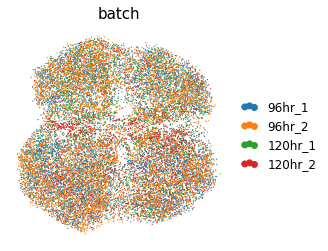

In [11]:
sc.pl.umap(adata, 
           color='batch', 
           use_raw=False, 
           frameon=False)


However, if we look at cell sex markers like rox1 and rox2, we see that cell sex is a strong confounder in our data. 

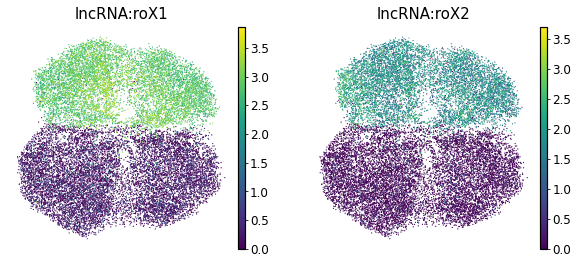

In [12]:
sc.pl.umap(adata, color=["lncRNA:roX1", "lncRNA:roX2"], frameon=False)

Likewise, if we look at a cell cycle marker like `PCNA`, we see that cell cycle has a major effect on our latent represenation. 

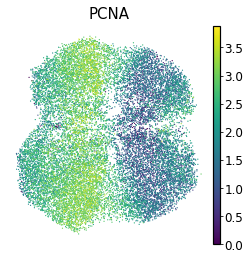

In [13]:
sc.pl.umap(adata, color="PCNA", frameon=False)

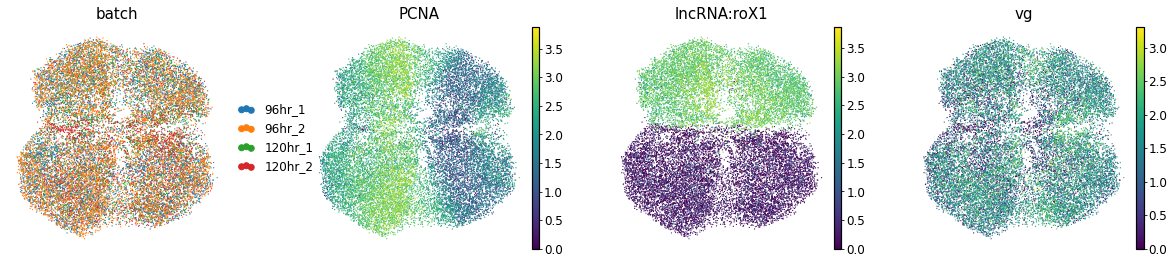

In [14]:
fig = sc.pl.umap(
    adata,
    color=["batch", "PCNA", "lncRNA:roX1", "vg"],
    frameon=False,
    wspace=0.25,
    return_fig=True,
)
fig.savefig("figs/dros_no_correct_umap.pdf", bbox_inches="tight", dpi=DPI)

The effects of cell cycle and cell sex ends up affecting the represenation of genes we are interested in like `Nrt`, `ptc`, and `mid`. We want to visualize these genes independant of cell sex and cell cycle, which will motivate our next section.

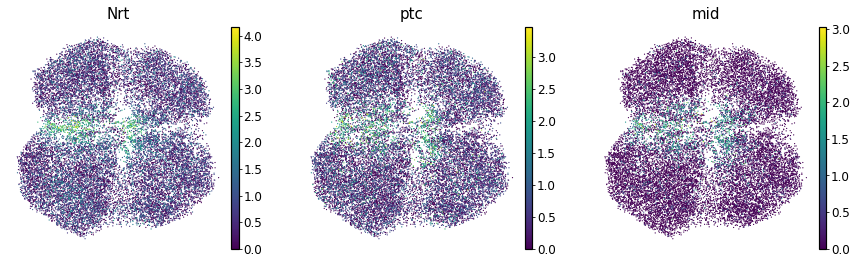

In [15]:
sc.pl.umap(adata, color=["Nrt", "ptc", "mid"], frameon=False)

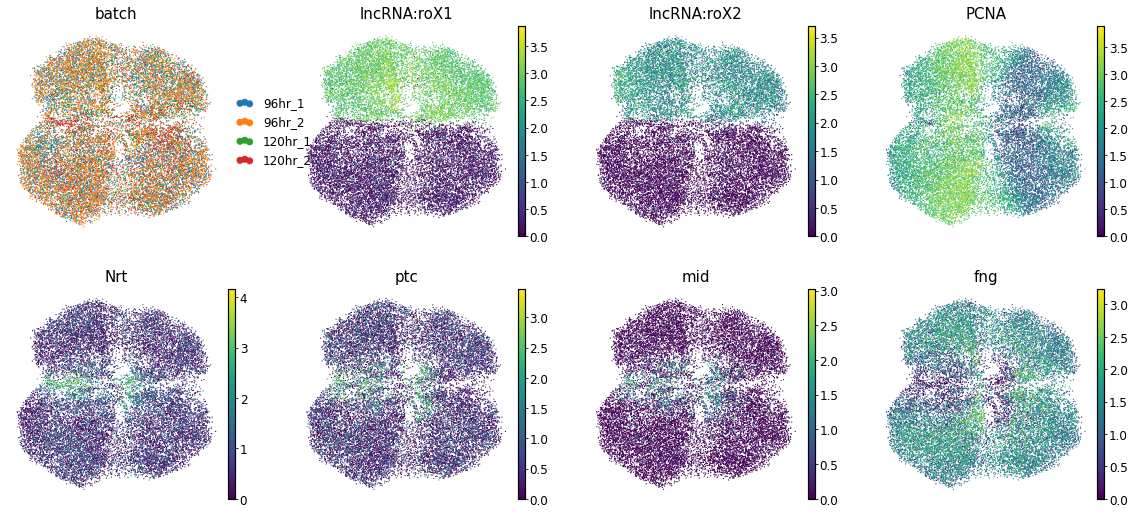

In [16]:
sc.pl.umap(
    adata,
    color=["batch", "lncRNA:roX1", "lncRNA:roX2", "PCNA", "Nrt", "ptc", "mid", "fng"],
    frameon=False,
)

# scVI with extra covariates

In this second part of the tutorial, we train scVI on extra categorical covariates. 

In our case, we would like to condition our latent represenation on cell cycle and cell sex gene expression in order to learn a latent representation that is independant of cell sex and cell cycle. 

## Training

In [17]:
cond_model = scvi.model.SCVI(adata_cond)
cond_model.train()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 400/400: 100%|██████████| 400/400 [06:37<00:00,  1.01it/s, loss=2.54e+03, v_num=1]


## Visualization

Here we visualize the latent space of our `scVI` model trained with expression from our nuisance genes as a continuous covariate.

In [18]:
adata_cond.obsm['X_scvi'] = cond_model.get_latent_representation()
sc.pp.neighbors(adata_cond, use_rep = 'X_scvi')
sc.tl.umap(adata_cond)

Again, we see scVI do a good job correcting for batch effects.

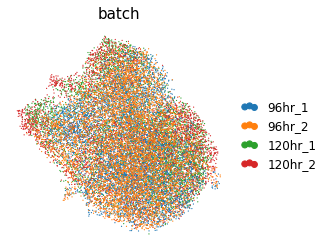

In [19]:
sc.pl.umap(adata_cond,
           color='batch',
           use_raw=True, 
           frameon=False)

Previously we saw strong signal from cell sex markers, `rox1` and `rox2`, in our latent space. Now that we condition on the cell sex genes, that signal has been removed.

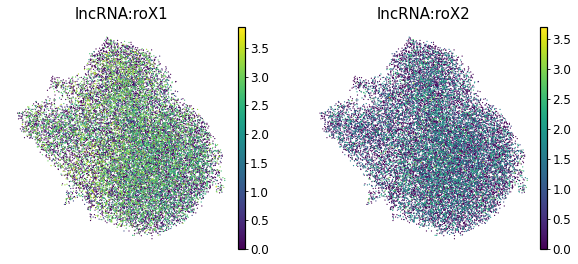

In [20]:
sc.pl.umap(adata_cond, color=["lncRNA:roX1", "lncRNA:roX2"], frameon=False)

Likewise, if we look at a cell cycle marker `PCNA`, we now no longer see the effects of cell cycle in our latent space.

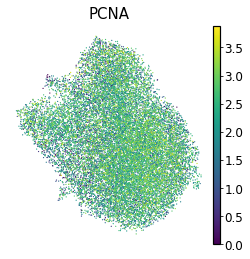

In [21]:
sc.pl.umap(adata_cond, color="PCNA", frameon=False)

Finally, we look at the represenation of genes we are interested in like `Nrt`, `ptc`, and `mid`. With the signal from cell sex and cell cycle removed from the latent space, the representation of genes we are interested in looks much better!

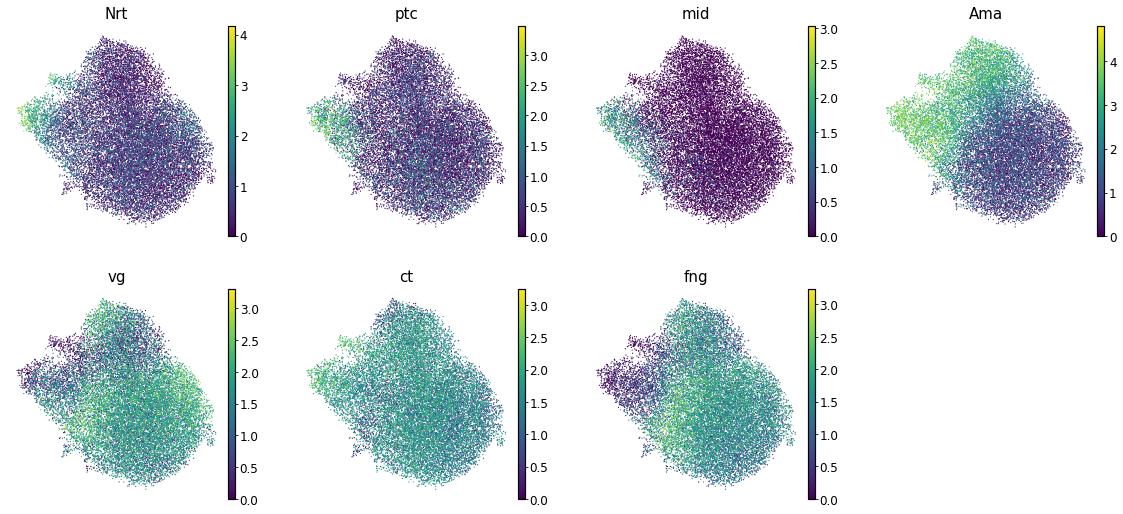

In [22]:
sc.pl.umap(
    adata_cond, color=["Nrt", "ptc", "mid", "Ama", "vg", "ct", "fng"], frameon=False
)

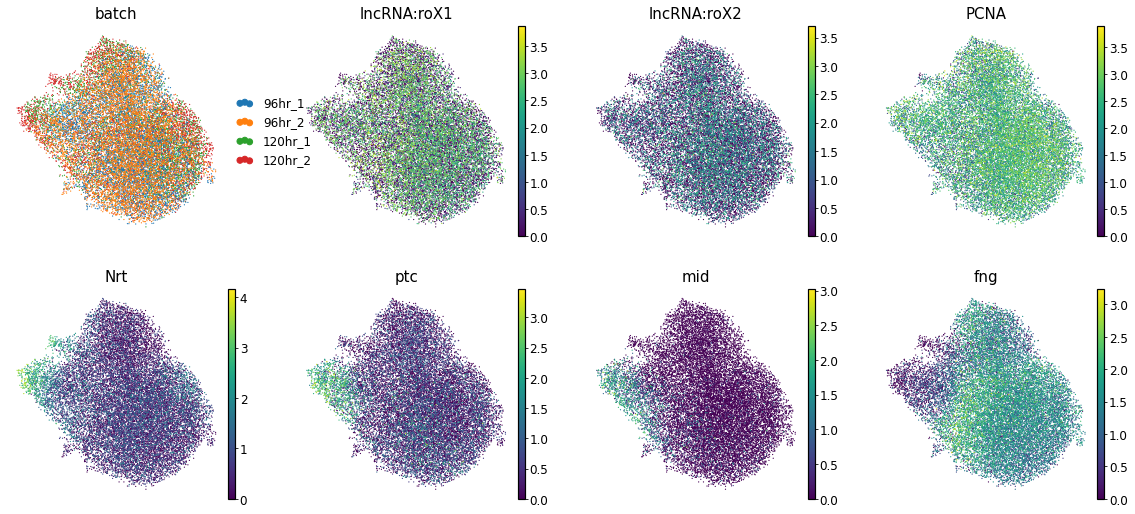

In [23]:
sc.pl.umap(
    adata_cond,
    color=["batch", "lncRNA:roX1", "lncRNA:roX2", "PCNA", "Nrt", "ptc", "mid", "fng"],
    frameon=False,
)

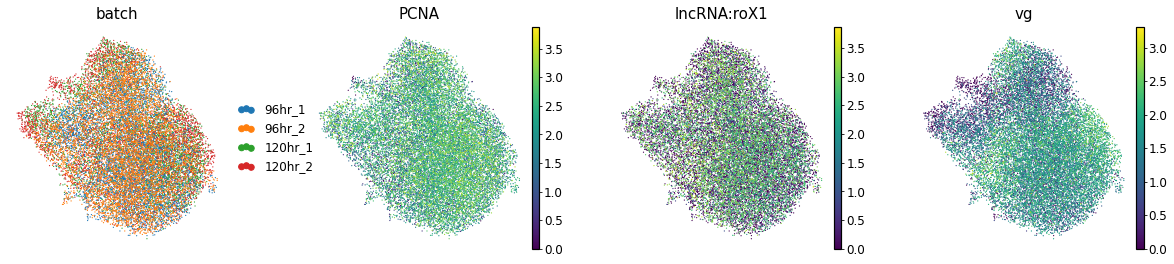

In [24]:
fig = sc.pl.umap(
    adata_cond,
    color=["batch", "PCNA", "lncRNA:roX1", "vg"],
    frameon=False,
    wspace=0.25,
    return_fig=True,
)
fig.savefig("figs/dros_with_correct_umap.pdf", bbox_inches="tight", dpi=DPI)

# Geary's C Analysis

Here we calculate Geary's C for our nuisance genes and genes of interest of our two models.

But first we run scanpy's `regress_out()` as a baseline.

In [25]:
# takes ~ 15 min to run 
adata_regress_out = sc.pp.regress_out(adata_cond, nuisance_genes, copy=True)


In [26]:
sc.pp.scale(adata_regress_out)
sc.tl.pca(adata_regress_out)
sc.external.pp.bbknn(adata_regress_out)
sc.tl.umap(adata_regress_out)

If we visualize the output of regress out, it doesn't perform any batch correction. 

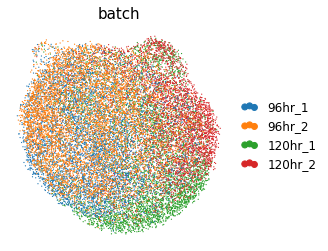

In [27]:
sc.pl.umap(adata_regress_out, 
           color='batch', 
           use_raw=False, 
           frameon=False)

Within a batch, regress out corrects for cell cycle and cell sex expression.

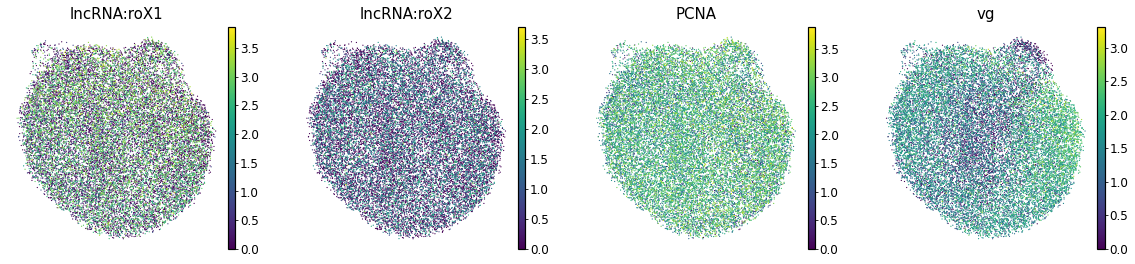

In [28]:
sc.pl.umap(
    adata_regress_out,
    color=[
        "lncRNA:roX1",
        "lncRNA:roX2",
        "PCNA",
        "vg",
    ],
    frameon=False,
)

However, we can see that it doesn't do a great job for genes we're interested in. 

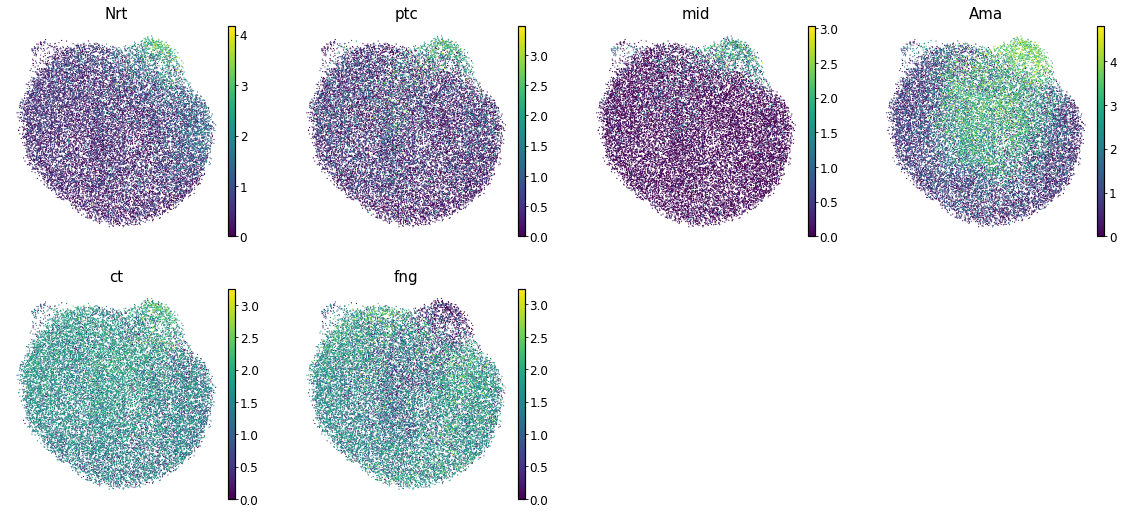

In [29]:
sc.pl.umap(
    adata_regress_out, color=["Nrt", "ptc", "mid", "Ama", "ct", "fng"], frameon=False
)

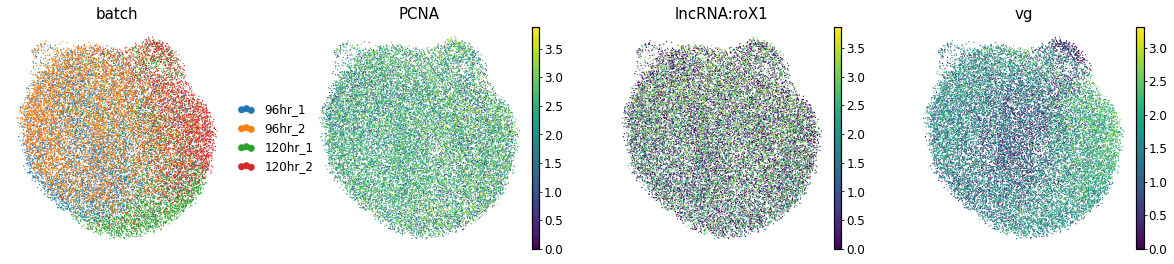

In [30]:
fig = sc.pl.umap(
    adata_regress_out,
    color=["batch", "PCNA", "lncRNA:roX1", "vg"],
    frameon=False,
    wspace=0.25,
    return_fig=True,
)
fig.savefig("figs/dros_regress_umap.pdf", bbox_inches="tight", dpi=DPI)

Calculating Geary's C 

In [31]:
genes = nuisance_genes + genes_of_interest
# genes = nuisance_genes + gene_subset
# genes = nuisance_genes + gene_subset
#calculate Geary's C for regular scvi model
vanilla_gc = gearys_c(adata, vals= adata.raw[:, genes].X.T)

#calculate Geary's C for scvi + conditioning
cond_gc = gearys_c(adata_cond, vals= adata_cond.raw[:, genes].X.T)

#calculate Geary's C for regress_out
regress_out_gc = gearys_c(adata_regress_out, vals= adata_regress_out.raw[:, genes].X.T)


In [32]:
gc = pd.DataFrame(data = np.concatenate((vanilla_gc, cond_gc, regress_out_gc)),
                  columns=["Geary's C"], index = genes * 3)
gc['model'] = (['scVI'] * len(genes) +
               ['scVI-cc'] * len(genes) + 
               ['Scanpy'] * len(genes))
is_nuisance = [True] * len(nuisance_genes) + [False] * len(genes_of_interest)
gc['is_nuisance'] = is_nuisance * 3


Now we can compare the Geary's C of genes between our models. A Geary's C close to 1 means the expression is uncorrelated with spatial position while values closer to 0 means the expression is positively correlated with spatial position. 

For genes that we condition on, we would expect to see Geary's C values closer to 1. This means that genes expression is uncorrelated with the spatial position in the latent space.



In [33]:
non_nuisance_gc =  gc[gc['is_nuisance']==False]
nuisance_gc = gc[gc['is_nuisance']==True]

In the below plot, we see that conditioning on cell cycle and cell sex genes increases the Geary's C of those genes compared to not conditioning.

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


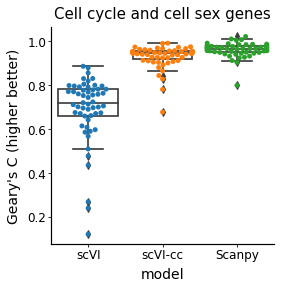

In [38]:
fig, ax = plt.subplots()
sns.swarmplot(
    y="Geary's C",
    x="model",
    data=nuisance_gc,
    order=["scVI", "scVI-cc", "Scanpy"],
    ax=ax
)
sns.boxplot(
    x="model",
    y="Geary's C",
    data=nuisance_gc,
    order=["scVI", "scVI-cc", "Scanpy"],
#     showcaps=,
    boxprops={"facecolor": "None"},
#     showfliers=True,
    ax=ax
)
ax.set_ylabel("Geary's C (higher better)")
ax.set_title("Cell cycle and cell sex genes")
fig.savefig("figs/boxplot_geary1.pdf", bbox_inches="tight")

We can also run a Wilcoxon rank-sum test to show that the difference in Geary's C between the models is statistically significant.

In [35]:
scvi_gc = nuisance_gc[nuisance_gc['model'] == 'scVI']["Geary's C"]
covariate_gc = nuisance_gc[nuisance_gc['model'] == 'scVI-cc']["Geary's C"]
regress_gc = nuisance_gc[nuisance_gc['model'] == 'Scanpy']["Geary's C"]

print(ranksums(scvi_gc,covariate_gc))
print(ranksums(scvi_gc, regress_gc))

RanksumsResult(statistic=-8.671299312233483, pvalue=4.272170649685279e-18)
RanksumsResult(statistic=-8.994119141851275, pvalue=2.3813407594969545e-19)


If we look at select genes we didn't condition on, we see that the Geary's C doesn't really change between the two models.

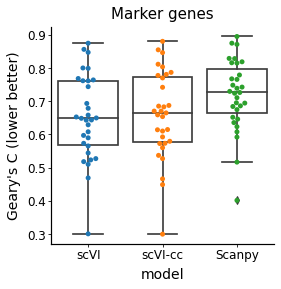

In [39]:
fig, ax = plt.subplots()

sns.swarmplot(
    y="Geary's C",
    x="model",
    data=non_nuisance_gc,
    order=["scVI", "scVI-cc", "Scanpy"],
    ax=ax
)
sns.boxplot(
    x="model",
    y="Geary's C",
    data=non_nuisance_gc,
    order=["scVI", "scVI-cc", "Scanpy"],
#     showcaps=False,
    boxprops={"facecolor": "None"},
#     showfliers=False,
    ax=ax
)
ax.set_ylabel("Geary's C (lower better)")
ax.set_title("Marker genes")
fig.savefig("figs/boxplot_geary2.pdf", bbox_inches="tight")

We can also run a Wilcoxon rank-sum test to show that the difference in Geary's C between the models is not statistically significant.

In [37]:
scvi_gc = non_nuisance_gc[non_nuisance_gc['model'] == 'scVI']["Geary's C"]
covariate_gc = non_nuisance_gc[non_nuisance_gc['model'] == 'scVI-cc']["Geary's C"]
regress_gc = non_nuisance_gc[non_nuisance_gc['model'] == 'Scanpy']["Geary's C"]

print(ranksums(scvi_gc,covariate_gc))
print(ranksums(scvi_gc, regress_gc))

RanksumsResult(statistic=-0.4997893615082406, pvalue=0.6172234022803302)
RanksumsResult(statistic=-2.231453909832567, pvalue=0.02565107727959247)
